# Strike-slip fault

In this final tutorial, we will simulate earthquakes and slow slip events on a 1D strike-slip fault (in a 2D medium; after _Tse & Rice, 1986_ ). The fault is a vertically-dipping, right-lateral strike-slip fault, of which the frictional part extends down to 30 km. This fault is loaded at a typical plate rate of 35 mm/yr. Over the simulated duration of 300 years, the fault may experience stable creep, slow slip, or fast slip (earthquakes) depending on the frictional properties (rate-and-state friction parameters). The parameter values are calculated based on the temperature $T$ at depth $z$, given as $T(z) = z \nabla T$, where $\nabla T$ is the (constant) geothermal gradient.

In [1]:
# Make plots interactive in the notebook
%matplotlib notebook

import matplotlib.pyplot as plt
import numpy as np

import os
import sys

# Add QDYN source directory to PATH
base_dir = os.path.expanduser("~")
qdyn_dir = os.path.join(base_dir, "qdyn", "src")
plot_dir = os.path.join(base_dir, "qdyn", "utils", "post_processing")
sys.path.append(qdyn_dir)
sys.path.append(plot_dir)

# Import QDYN wrapper and plotting library
from pyqdyn import qdyn
import plot_functions as qdyn_plot

We prepare the simulation in our usual way:

In [2]:
# Instantiate the QDYN class object
p = qdyn()

# Number of fault segments
N = np.power(2, 11)

# Number of seconds per year
t_yr = 3600 * 24 * 365.0

# Plate velocity = 35 mm/yr
V = 35e-3 / t_yr

# Python dictionary with general settings
set_dict = {
    "N": N,                     # number of fault segments
    "NXOUT": np.power(2,1),     # snapshot output spacing
    "NTOUT": 100,               # snapshot output frequency
    "ACC": 1e-7,                # Solver accuracy
    "MU": 30e9,                 # Shear modulus [Pa]
    "DTTRY": 1e-8,              # First time step (needs to be small)
    "TMAX": 300*t_yr,           # Run simulation 200 years
    "MESHDIM": 1,               # One-dimensional fault in 2D medium
    "VS": 3000,                 # Shear wave velocity [m/s]
    "L": 30.0e3,                # Fault length (depth)
    "FINITE": 3,                # Finite fault with free surface
    "IC": N//4,                 # Location for time-series output (7.5 km depth)
    "SOLVER": 2,                # Runge-Kutta solver
    "V_PL": V,                  # Loading (plate) velocity [m/s]
}

# Python dictionary with rate-and-state friction parameters
set_dict_RSF = {
    "RNS_LAW": 0,       # using classical rate-and-state
    "THETA_LAW": 1,     # using the ageing law
    "DC": 40e-3,        # Dc = 40 mm
    "V_0": V,           # Initial velocity
    "V_SS": V,          # Reference velocity
}

# Set state variable near steady-state value
set_dict_RSF["TH_0"] = 0.99*set_dict_RSF["DC"]/set_dict_RSF["V_0"]
set_dict["SET_DICT_RSF"] = set_dict_RSF

""" Step 1: Compute depth-dependent parameters """
# Depth vector
z = np.linspace(0, set_dict["L"], N)

# Temperature vector
dTdz = 25e-3
T = dTdz * z

# RSF parameters
a = 3.28e-5*T - 9.288e-3
a_min_b = a
a = np.clip(a, a_min=0.004, a_max=10)
a_min_b = np.clip(a_min_b, a_min=-0.0029, a_max=10)
b = -(a_min_b - a)

# Effective normal stress
sigma = 18e3 * z + 1e7

""" Step 2: Set (default) parameter values and generate mesh """
p.settings(set_dict)
p.render_mesh()

""" Step 3: override default mesh values """
p.mesh_dict["SIGMA"] = sigma
p.mesh_dict["A"] = a
p.mesh_dict["B"] = b

# Write input to qdyn.in
p.write_input()

True

We can visualise the two asperities by plotting $(a-b)$ versus position on the fault:

<IPython.core.display.Javascript object>


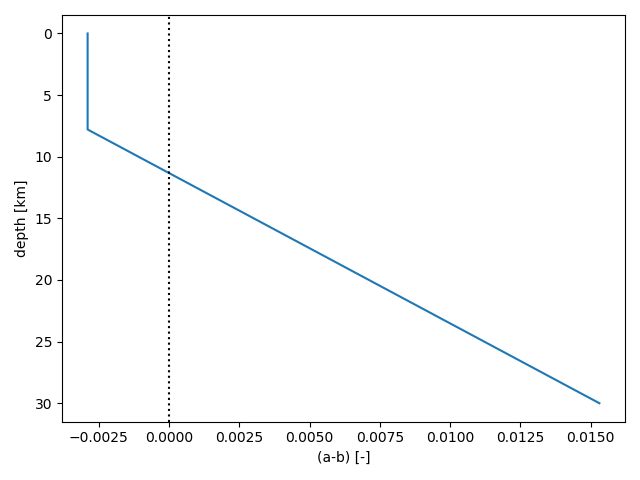

In [3]:
plt.close("all")
plt.clf()
plt.plot(p.mesh_dict["A"] - p.mesh_dict["B"], z * 1e-3)
plt.axvline(0, ls=":", c="k")
plt.ylabel("depth [km]")
plt.xlabel("(a-b) [-]")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

We then run this simulation with `p.run()`

In [4]:
p.run()

0

Then read the output:

In [5]:
p.read_output()

True

To get a general impression of how our fault behaved, we plot the time series of the shear stress $\tau$, state $\theta$, and slip rate $v$ recorded at the location where $v$ is maximum.

<IPython.core.display.Javascript object>


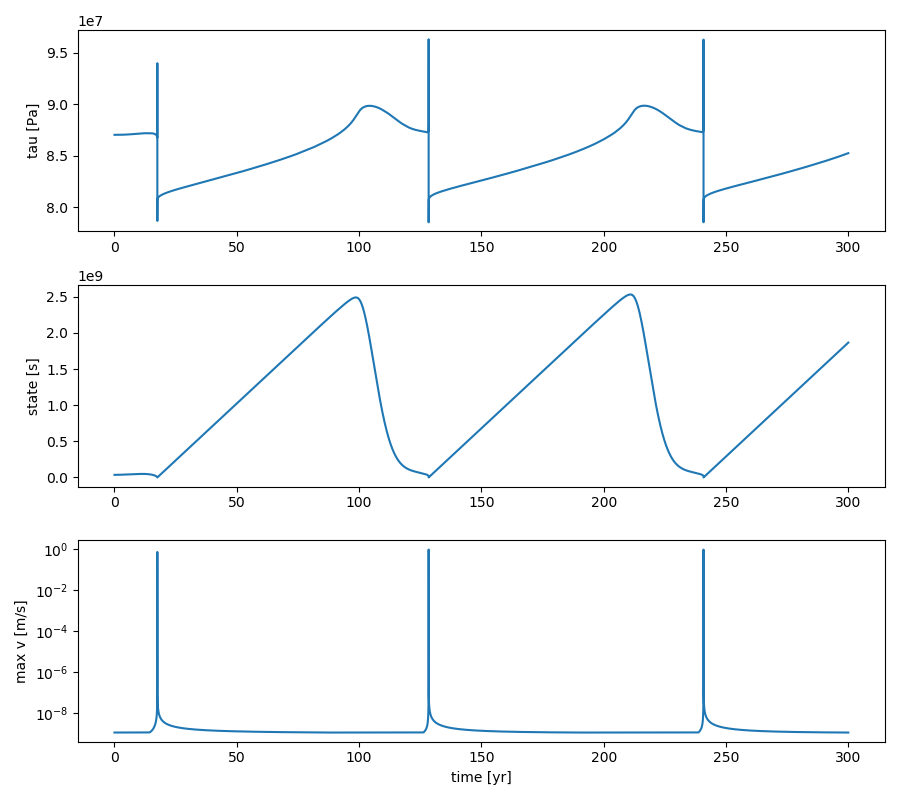

In [6]:
# Time series of stress, state, and maximum slip rate on the fault
qdyn_plot.timeseries(p.ot)

In this double-asperity scenario, we see the opposite of what we saw in the single-asperity case: instead of converging to a stable limit cycle, the earthquake cycles diverge into (deterministic) chaos. This is clearly illustrated by the slip rate evolution:

<IPython.core.display.Javascript object>


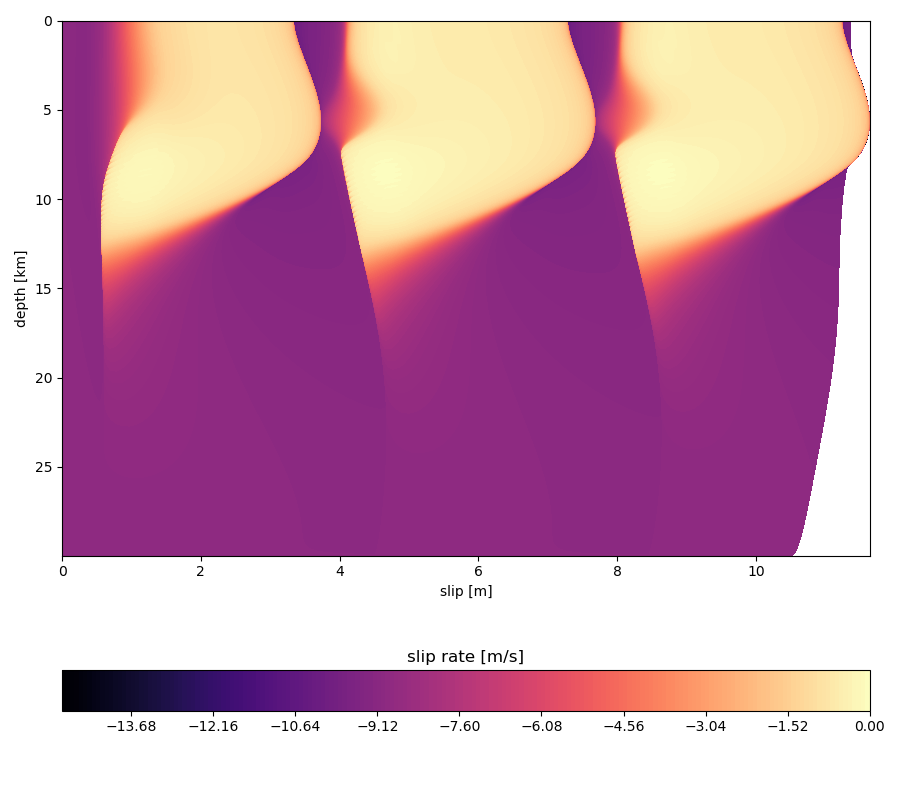

In [7]:
# Spatio-temporal evolution of slip rates
qdyn_plot.slip_profile(p.ox, orientation="vertical")

At first, both asperities rupture simultaneously, but after a few cycles, only the left asperity ruptures seismically while the right one mostly creeps. This pattern is reversed after a few more cycles. Another way of seeing this is with an animation:

In [8]:
# This will take a minute or two...
qdyn_plot.animation_slip(p.ox, orientation="vertical")

## Exercise

In certain regions of the world, like in New Zealand, the geothermal gradient far exceeds values typical for the continental crust (around 25 $^{\circ}$C/km vs. over 100 $^{\circ}$C/km in some regions). We can see the effect of a much steeper geotherm by increasing `dTdz` in the script file. Your mission, should you choose to accept it, is to systematically vary `dTdz` to identify transitions from fast slip to slow slip to creep, and to think about _why_ the mode of slip changes. 